# Demo

We run a minimum risk portfolio and perform an entire backtest

In [1]:
import pandas as pd
import cvxpy as cp

from cvx.simulator.builder import builder

In [2]:
# Load some historic stock prices
prices = pd.read_csv('data/stock_prices.csv', index_col=0, parse_dates=True, header=0)

In [3]:
# Estimate a series of historic covariance matrices
returns = prices.pct_change().dropna(axis=0, how="all")
cov = returns.ewm(com=60, min_periods=100).cov().dropna(axis=0, how="all")
start = cov.index[0][0]

In [4]:
# Establish a risk model
from cvx.risk.sample import SampleCovariance_Product
risk_model = SampleCovariance_Product(num=20)

In [5]:
# Solver for minimum risk portfolio
from cvx.risk import RiskModel

def minimum_risk(w: cp.Variable, risk_model: RiskModel) -> cp.Problem:
    """Constructs a minimum variance portfolio.

    Args:
        w: cp.Variable representing the portfolio weights.
        risk_model: A risk model.

    Returns:
        A convex optimization problem.
    """
    return cp.Problem(
        cp.Minimize(risk_model.estimate_risk(w)),
        [cp.sum(w) == 1, w >= 0]
    )

In [6]:
# Perform the backtest
_builder = builder(prices=prices.truncate(before=start), initial_cash=1e6)

w = cp.Variable(len(_builder.assets))

for t, _ in _builder:
    risk_model.cov.value = cov.loc[t[-1]].values
    minimum_risk(w, risk_model).solve()
    _builder.set_weights(t[-1], w.value)

portfolio = _builder.build()


<Axes: xlabel='date'>

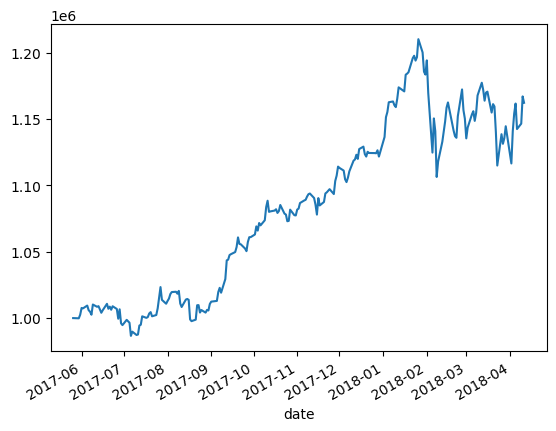

In [7]:
portfolio.nav.plot()

## Change of risk model

In [8]:
from cvx.risk.cvar import CVar
risk_model = CVar(alpha=0.80)

In [9]:
# Perform the backtest
_builder = builder(prices=prices.truncate(before=start), initial_cash=1e6)

w = cp.Variable(len(_builder.assets))

for t, _ in _builder:
    risk_model.R = returns.truncate(after=t[-1]).tail(40).values
    minimum_risk(w, risk_model).solve()
    _builder.set_weights(t[-1], w.value)

portfolio = _builder.build()

<Axes: xlabel='date'>

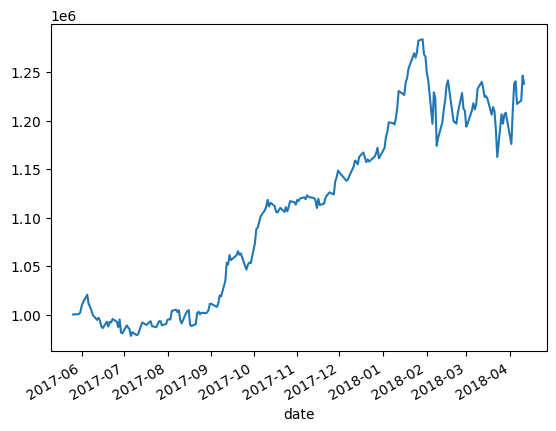

In [10]:
portfolio.nav.plot()